In [13]:
! pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.1/452.1 kB 17.1 MB/s eta 0:00:00


In [252]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### Load data

In [253]:
# read filtered data from csv, using proper data type and with index
df_filtered = pd.read_csv('filtered_data.csv',index_col=0 ,dtype={'Age_Group': 'int64', 'C_EDU_Encoded': 'int64', 'C_HSE_Encoded': 'int64', 'C_OCC_Encoded': 'int64', 'INCM_TYP': 'int64', 'NUM_PRD': 'int64', 'IS_CASA': 'int64', 'CASATD_CNT': 'int64', 'CASA_DIFF': 'float64', 'DRvCR': 'float64', 'IS_TD': 'int64', 'IS_FUNDS': 'int64', 'IS_CC': 'int64', 'IS_LOAN': 'int64', 'CC_MTH_TRN_AMT_DIFF': 'int64', 'CC_LMT': 'int64', 'LoanAsset_ratio': 'float64', 'AssetvCValue': 'float64', 'Customer_Bank_engagement': 'float64', 'C_seg': 'int8'})
df_filtered.head()

,Age_Group,C_EDU_Encoded,C_HSE_Encoded,C_OCC_Encoded,INCM_TYP,NUM_PRD,IS_CASA,CASATD_CNT,CASA_DIFF,DRvCR,IS_TD,IS_FUNDS,IS_CC,IS_LOAN,CC_MTH_TRN_AMT_DIFF,CC_LMT,LoanAsset_ratio,AssetvCValue,Customer_Bank_engagement,C_seg
0,3,3,2,2,6,3,1,8,3988.20,1020767.0,1,0,1,0,0,34500,1.118960e+15,0.083333,111896.0,0
1,4,0,2,2,2,4,1,13,34422.30,8.0,1,0,1,0,8257,4000,6.272860e+15,0.083030,629581.0,0
2,4,0,0,2,3,4,1,1,0.00,0.0,0,1,1,0,401,5000,6.416100e+14,0.505762,64127.0,0
3,4,0,0,1,2,3,1,1,0.00,5397.0,0,1,0,0,0,0,3.979200e+14,0.207234,42459.0,0
4,4,0,2,1,0,4,1,2,13740.68,3607.0,0,1,0,0,0,0,6.725800e+14,0.105963,66699.0,0


In [254]:
# Split the data into features and target variable
X = df_filtered.drop('C_seg', axis=1)
y = df_filtered['C_seg']

### Define helper function for classifier reports

In [255]:
from typing import Any, List, Tuple
import seaborn as sns

def plot_customer_engagement_by_product(df, columns):
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(20, 5))
    for i, col in enumerate(columns):
        sns.barplot(x='y_pred', y='Customer_Bank_engagement', hue=col, data=df, ax=axes[i])
        axes[i].set_title(f"Sum of Engagement by {col} and Segment")
        for p in axes[i].patches:
            axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
        axes[i].set_xticklabels(['Affluent', 'Normal'])
        axes[i].legend(title=col, loc='upper right')
        axes[i].set_xlabel('Segment')
        axes[i].set_ylabel('Customer Bank engagement')
    plt.tight_layout()
    plt.show()

def plot_average_customer_bank_engagement_by_customer_segment(X: pd.DataFrame, y, y_pred) -> None:
    """
    Plot the average customer bank engagement by customer segment.

    Parameters:
    X (pd.DataFrame): The input DataFrame.
    y: The target variable.
    y_pred: The predicted labels.
    """

    columns = [ 'IS_CASA', 'IS_TD', 'IS_CC', 'IS_FUNDS', 'IS_LOAN']

    df_new = pd.concat([X, y], axis=1)
    df_new['y_pred'] = y_pred

    # Plot the average customer bank engagement by customer segment
    (df_new.groupby('y_pred')['Customer_Bank_engagement'].sum() / df_new['y_pred'].value_counts()).plot(kind='bar')
    plt.title('Average Customer Bank engagement by Customer segment')
    plt.xticks(ticks=[0, 1], labels=['Affluent', 'Normal'], rotation=0)
    # show values on bar
    for i, v in enumerate((df_new.groupby('y_pred')['Customer_Bank_engagement'].sum() / df_new['y_pred'].value_counts())):
        plt.text(i, v, int(v), ha='center', va='bottom')
    plt.ylabel('Value')
    plt.xlabel('Customer Segment')
    plt.show()
    # total_monetary_value_of_affluent_customers = df_new[df_new['y_pred'] == 1]['Customer_Bank_engagement'].sum()
    # print(f"Total monetary value of affluent customers: {total_monetary_value_of_affluent_customers}")
    plot_customer_engagement_by_product(df_new, columns)

def get_hidden_affluent_customers(X: Any, y_true: Any, predicted_labels: Any) -> List:
    """
    Function to get the hidden affluent customers.

    Parameters:
    X (array-like): The input data.
    y_true (array-like): The true labels.
    predicted_labels (array-like): The predicted labels.

    Returns:
    hidden_affluent_customers_cv (array-like): The hidden affluent customers identified.
    """
    hidden_affluent_customers_cv = X[(predicted_labels == 0) & (y_true == 1)]  # identify original label as 1(Normal) and predicted label as 0(Hidden Affluent)
    print("\nNumber of hidden affluent customers identified:", len(hidden_affluent_customers_cv))

    original_affluent_customers = len(X[ (y_true == 0)] ) # identify original label as 1(Normal) and predicted label as 1(Affluent)
    print("Number of Existing affluent customers:", original_affluent_customers)

    return hidden_affluent_customers_cv


def get_classification_report(X: Any, y_true: Any, y_pred_proba: Any, threshold_in: float = 0.5, model_name: str = None, show_hidden_affluent: bool = True) -> Tuple[float, float, float, float, List]:
    """
    Get classification report for the model
    """
    positive_probs = y_pred_proba[:, 1]

    # Define threshold to classify as affluent customer
    threshold = threshold_in  # Example threshold (can be adjusted based on business requirements)
    # Classify instances based on threshold
    predicted_labels = (positive_probs >= threshold).astype(int)

    ### Code for classification evaluation metrics
    # Compute precision, recall, and F1-score
    precision = precision_score(y_true, predicted_labels, pos_label=0)
    recall = recall_score(y_true, predicted_labels, pos_label=0)
    f1 = f1_score(y_true, predicted_labels, pos_label=0)

    # Print model name as big heading if provided
    if model_name:
        print("#" * 50)
        print(f'\t\t{model_name}')
        print("#" * 50)

    print("Cross-validated Precision for class 0 (affluent customers):", precision)
    print("Cross-validated Recall for class 0 (affluent customers):", recall)
    print("Cross-validated F1-score for class 0 (affluent customers):", f1)

    ### Code for Hidden Affluent Customers
    hidden_affluent_df = get_hidden_affluent_customers(X, y_true, predicted_labels)
    if show_hidden_affluent:
        print(hidden_affluent_df.head())

    #### Code for ROC-AUC curve
    # Compute ROC curve and ROC-AUC
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = roc_auc_score(y_true, y_pred_proba[:, 1])

    # Plot ROC curve with model name in title if provided
    plt.figure(figsize=(8, 6))
    if model_name:
        plt.title(f"Receiver Operating Characteristic (ROC) Curve - {model_name}")
    else:
        plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    ### Code to plot average customer bank engagement by customer segment
    plot_average_customer_bank_engagement_by_customer_segment(X, y_true, predicted_labels)

    return precision, recall, f1, roc_auc, hidden_affluent_df

    

### Train Random Forest Classifier

In [256]:
# Initialize the RandomForestClassifier
clf = RandomForestClassifier(random_state=42)
# Initialize StratifiedKFold for cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Make cross-validated predictions
y_pred_cv = cross_val_predict(clf, X, y, cv=cv, method='predict_proba')

##################################################
		Random Forest Classifier
##################################################
Cross-validated Precision for class 0 (affluent customers): 0.642007303569325
Cross-validated Recall for class 0 (affluent customers): 0.5216309341500766
Cross-validated F1-score for class 0 (affluent customers): 0.5755927549242225

Number of hidden affluent customers identified: 3039
Number of Existing affluent customers: 10448


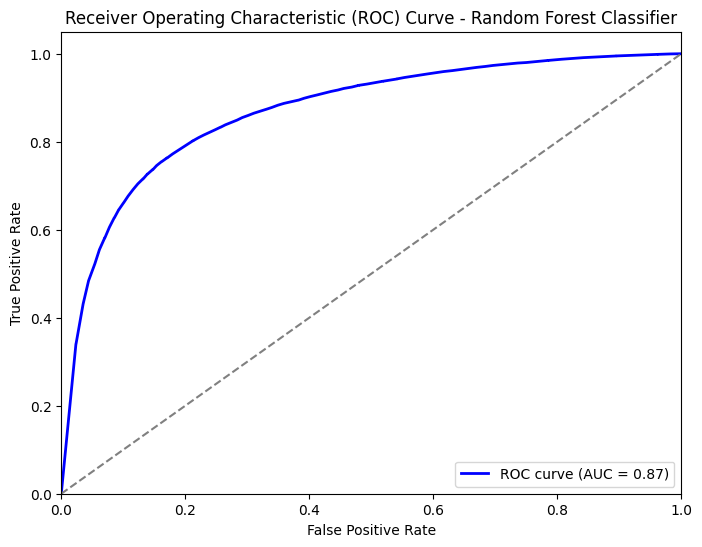

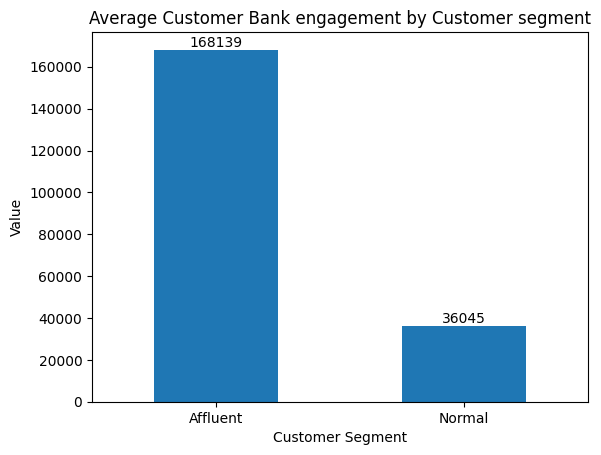

/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Affluent', 'Normal'])
/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Affluent', 'Normal'])
/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Affluent', 'Normal'])
/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].

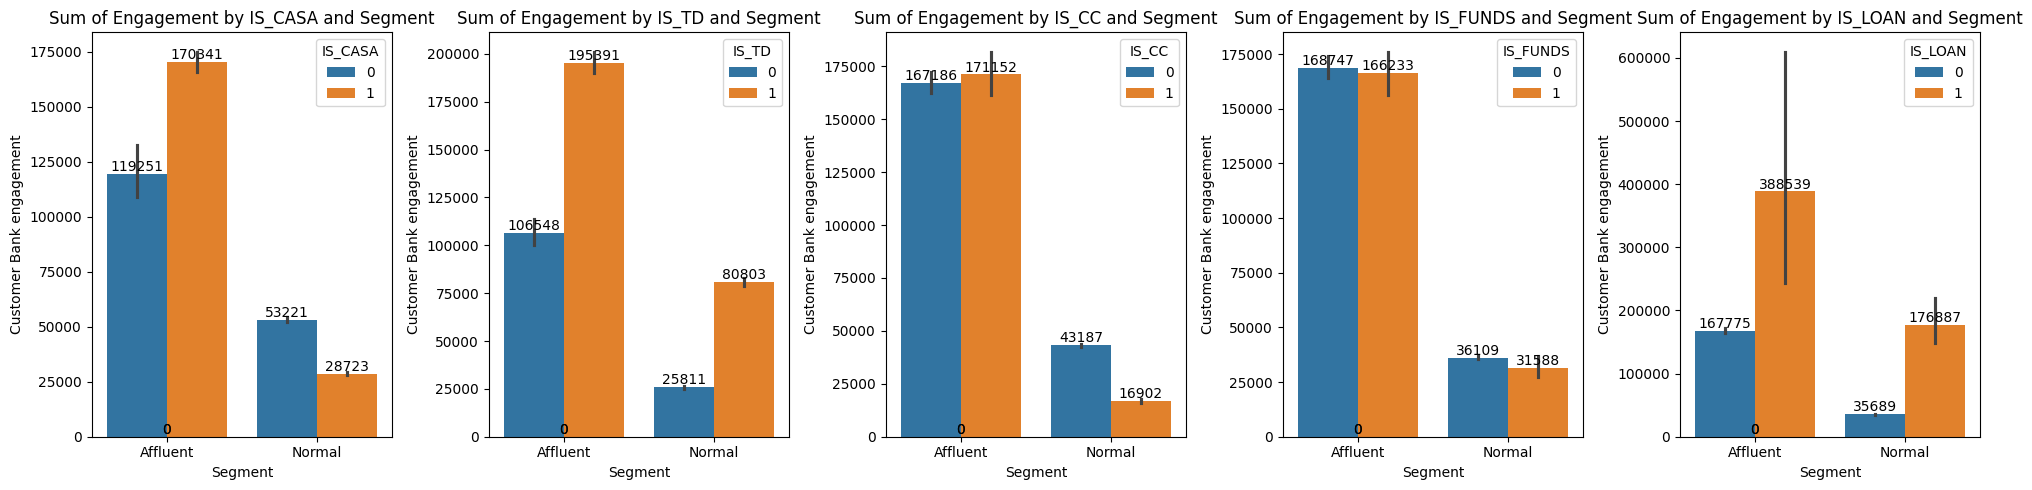

In [249]:
# get classification report
_ = get_classification_report(X,y, y_pred_cv,threshold_in=.50,model_name='Random Forest Classifier',show_hidden_affluent=False)

In [240]:
## Increase in Customer engagement as Monetary value increases in Affluent segment
Average_affleunt_engagement= 168139
total_affluent_customers = 10448+3039
new_total_engagement_affluent= Average_affleunt_engagement*total_affluent_customers

original_total_engagement_affluent= 1329093823
print("Original Total Monetary value of Affluent customers= {:,}".format(original_total_engagement_affluent))
print("New Total Monetary value of Affluent customers=  = {:,}".format(new_total_engagement_affluent))

#show increase in percentage of monetary value of affluent customers
percentage_increase = ((new_total_engagement_affluent-original_total_engagement_affluent)/original_total_engagement_affluent)*100
print("Percentage Increase in Total Monetary value of Affluent customers= {:.2f}%".format(percentage_increase))


Original Total Monetary value of Affluent customers= 1,329,093,823
New Total Monetary value of Affluent customers=  = 2,267,690,693
Percentage Increase in Total Monetary value of Affluent customers= 70.62%


### Train XGBoost classifier, with GridSearchCV for hyperparameter tuning

In [ ]:
parameters = {
    'max_depth': [4, 8],  
    'learning_rate': [0.1, 0.05],  
    'n_estimators': [100, 200], 
    'subsample': [0.8, 1],  
    'colsample_bytree': [0.9, 1] ,
    'gamma': [0, 0.1],
    'reg_lambda': [1, 5],
    'reg_alpha': [0, 1]
}

# Initialize the XGBoost classifier
xgb = XGBClassifier(objective= 'binary:logistic',seed=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(xgb, parameters, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

# Get the best parameters
best_params = grid_search.best_params_
best_params

In [183]:
best_params = {'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}

##################################################
		XGBoost Classifier
##################################################
Cross-validated Precision for class 0 (affluent customers): 0.6824906728418886
Cross-validated Recall for class 0 (affluent customers): 0.5077526799387443
Cross-validated F1-score for class 0 (affluent customers): 0.5822951539432523

Number of hidden affluent customers identified: 2468
Number of Existing affluent customers: 10448


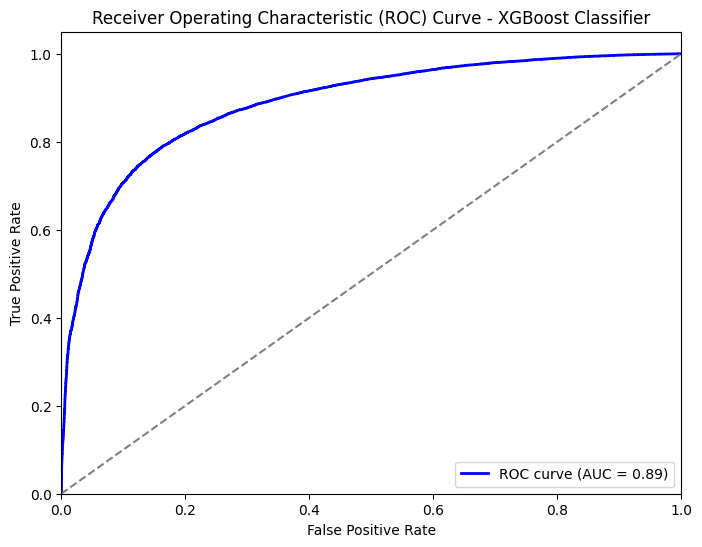

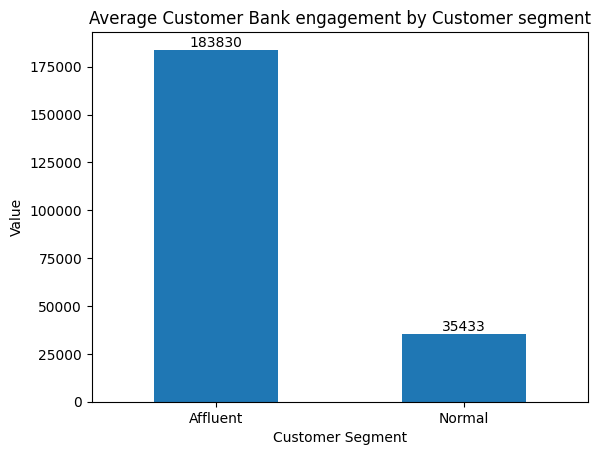

/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Affluent', 'Normal'])
/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Affluent', 'Normal'])
/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(['Affluent', 'Normal'])
/var/folders/yx/49mrr88n7wg_4mmyltrhrhdc0000gn/T/ipykernel_96070/202768276.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].

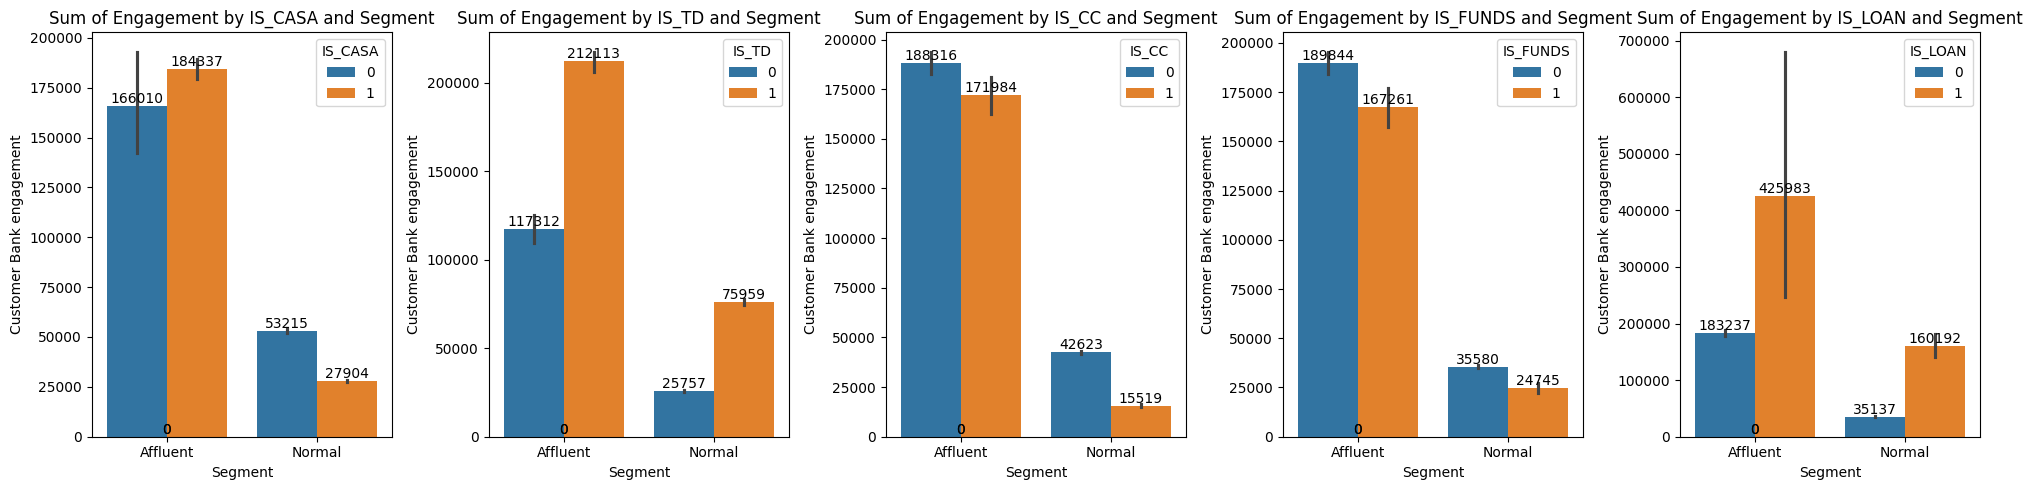

In [250]:
# Train and predict using the best parameters
xgb_best = XGBClassifier(objective= 'binary:logistic',seed=42,**best_params)
y_pred_xgb_proba = cross_val_predict(xgb_best, X, y, cv=5, method='predict_proba')

# get classification report
_ = get_classification_report(X,y, y_pred_xgb_proba,threshold_in=.50,model_name='XGBoost Classifier',show_hidden_affluent=False)

In [241]:
## Increase in Customer engagement as Monetary value increases in Affluent segment
Average_affleunt_engagement= 183830
total_affluent_customers = 10448+2468
new_total_engagement_affluent= Average_affleunt_engagement*total_affluent_customers

original_total_engagement_affluent= 1329093823
print("Original Total Monetary value of Affluent customers= {:,}".format(original_total_engagement_affluent))
print("New Total Monetary value of Affluent customers=  = {:,}".format(new_total_engagement_affluent))

#show increase in percentage of monetary value of affluent customers
percentage_increase = ((new_total_engagement_affluent-original_total_engagement_affluent)/original_total_engagement_affluent)*100
print("Percentage Increase in Total Monetary value of Affluent customers= {:.2f}%".format(percentage_increase))


Original Total Monetary value of Affluent customers= 1,329,093,823
New Total Monetary value of Affluent customers=  = 2,374,348,280
Percentage Increase in Total Monetary value of Affluent customers= 78.64%


### Help understand Model prediction better using Shaply

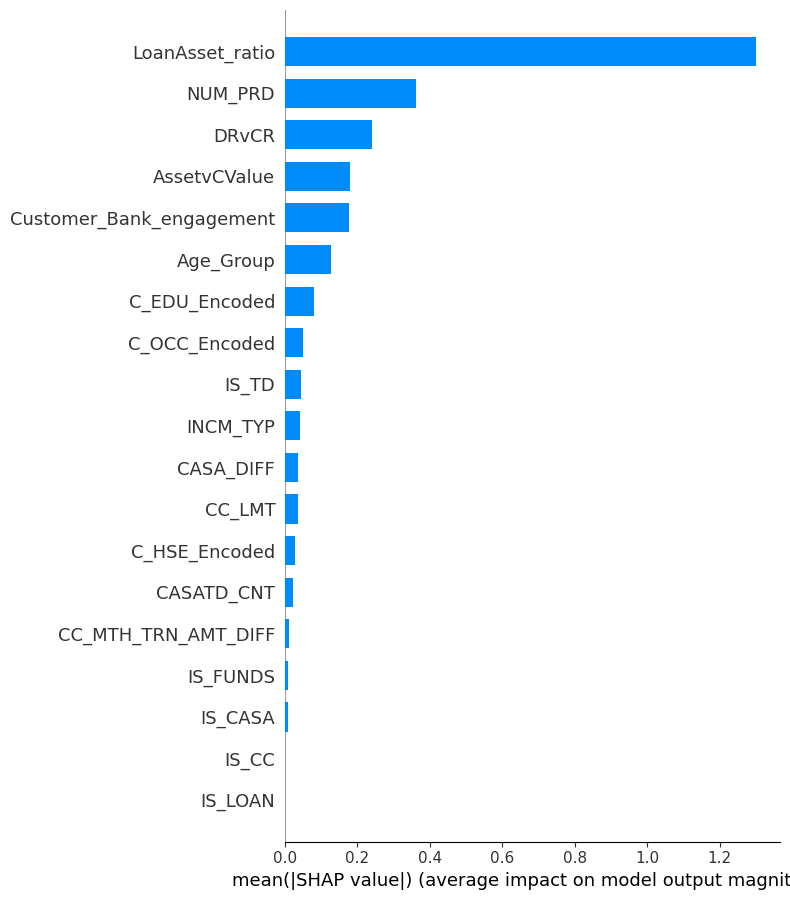

In [257]:
# use shaply to explain the model
import shap 
import warnings

shap.initjs()

# Train the model
xgb_best.fit(X, y)

# Create the explainer object
explainer = shap.TreeExplainer(xgb_best)

# Calculate Shap values
shap_values = explainer.shap_values(X)

# Summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

### To check decision Boundary for our prediction around probability (.40 -.50) and (.50-.60), what are our most important features in deciding
We've used, feature_order='hclust' to groups observations with similar prediction paths.
Insights:
1. (For .50-.60)There are not many outliers in the output, Effect of LoanAsset_ratio, DRvCR, NUM_PRD, AssetvCValue,Customer_engagement immediately stand out .
2. (For .40-.50) Few outliers are present which will require further inspection of individual record, but effect of LoanAsset_ratio, Age_group, NUM_PRD, AssetvCValue is present for deciding at major level.
3. For lower probability to not predict Affluent category, LoanAsset_ratio, Age_group, NUM_PRD, AssetvCValue important factor.

(3005, 19)


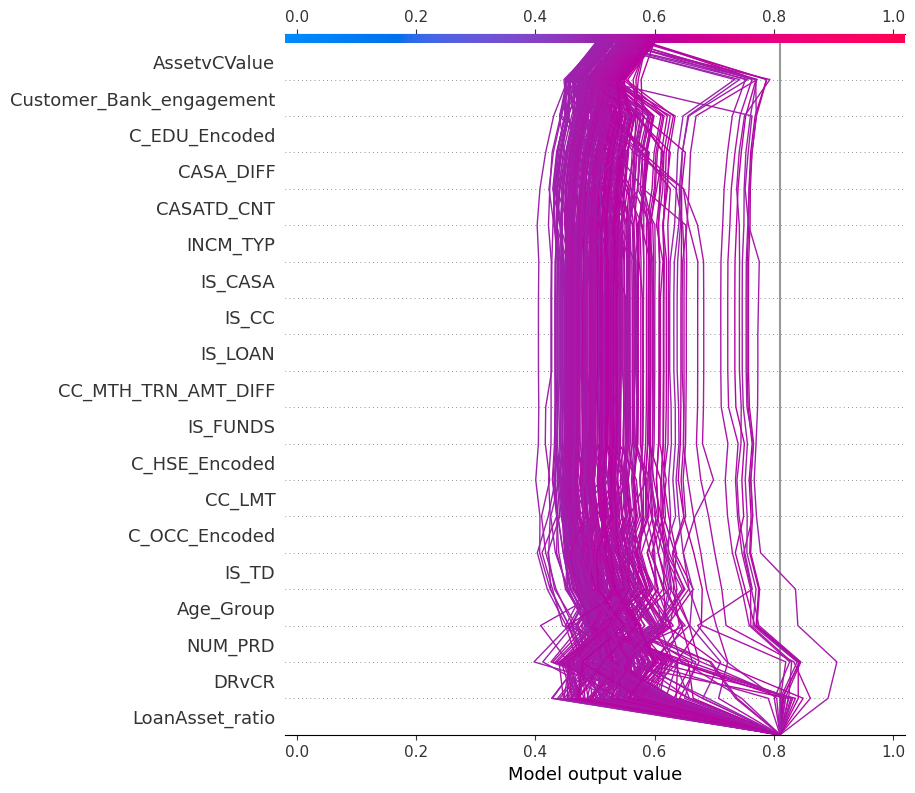

In [259]:
### For results interpretation and decision making between probability threshold of 0.50 and 0.60
y_pred = xgb_best.predict_proba(X)[:, 1]  # Get predictions on the probability scale.
T = X[(y_pred >= 0.50) & (y_pred <=.60)]  # Select the top 1% of customers with the highest probability of being affluent.
print(T.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T)[2750:,:]
shap.decision_plot(explainer.expected_value, sh, T, feature_order="hclust", link="logit", highlight=0)

(2480, 19)


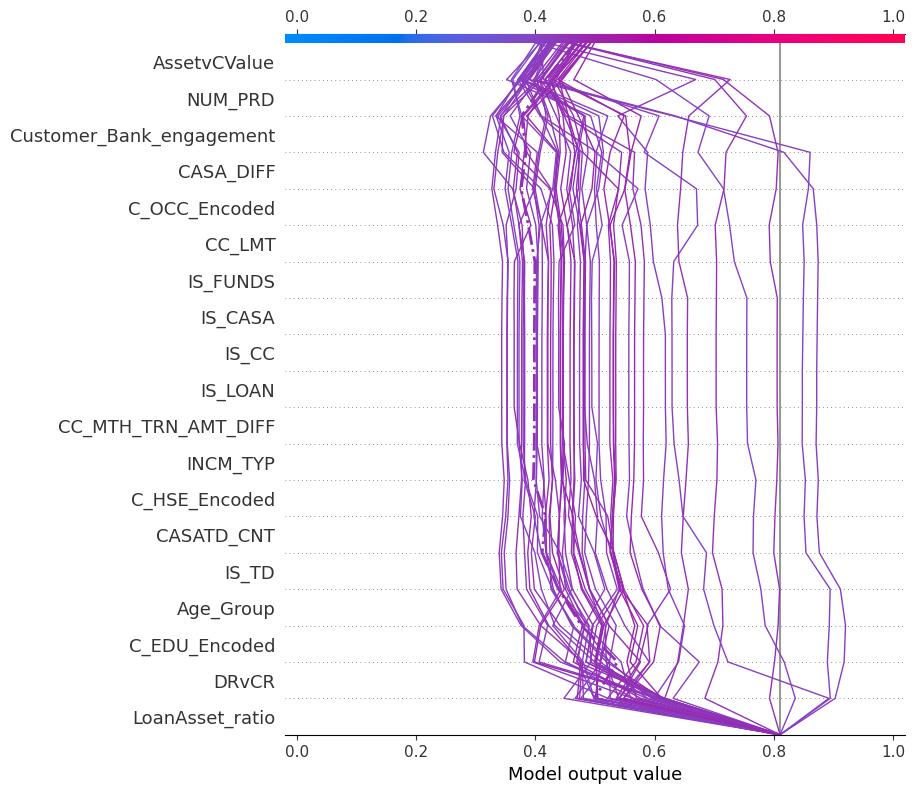

In [264]:
### For results interpretation and decision making between probability threshold of 0.45 and 0.50
# y_pred = xgb_best.predict_proba(X)[:, 1]  # Get predictions on the probability scale.
T_mid = X[(y_pred >= 0.40) & (y_pred <.50)]  # Select the top 1% of customers with the highest probability of being affluent.
print(T_mid.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T_mid)[100:150,:]
r= shap.decision_plot(explainer.expected_value, sh, T_mid, feature_order="hclust",link='logit', highlight=0,return_objects=True)

### Look inside individual decision plot with most negative IS_FUNDS value in database, for given probability

In [265]:
import numpy as np
sh = explainer.shap_values(T_mid)[100:150,:]
# Find the two observations with the most negative 'Customer_Bank_engagement' SHAP values.
idx = np.argpartition(sh[:, T_mid.columns.get_loc("Customer_Bank_engagement")], 2)[0:2]

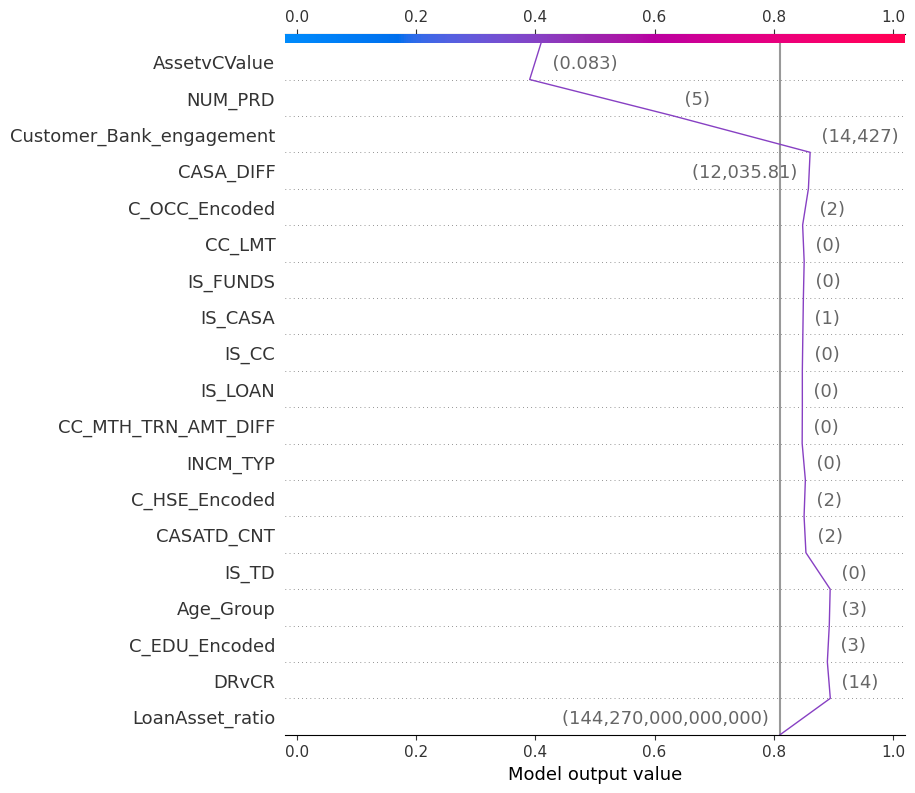

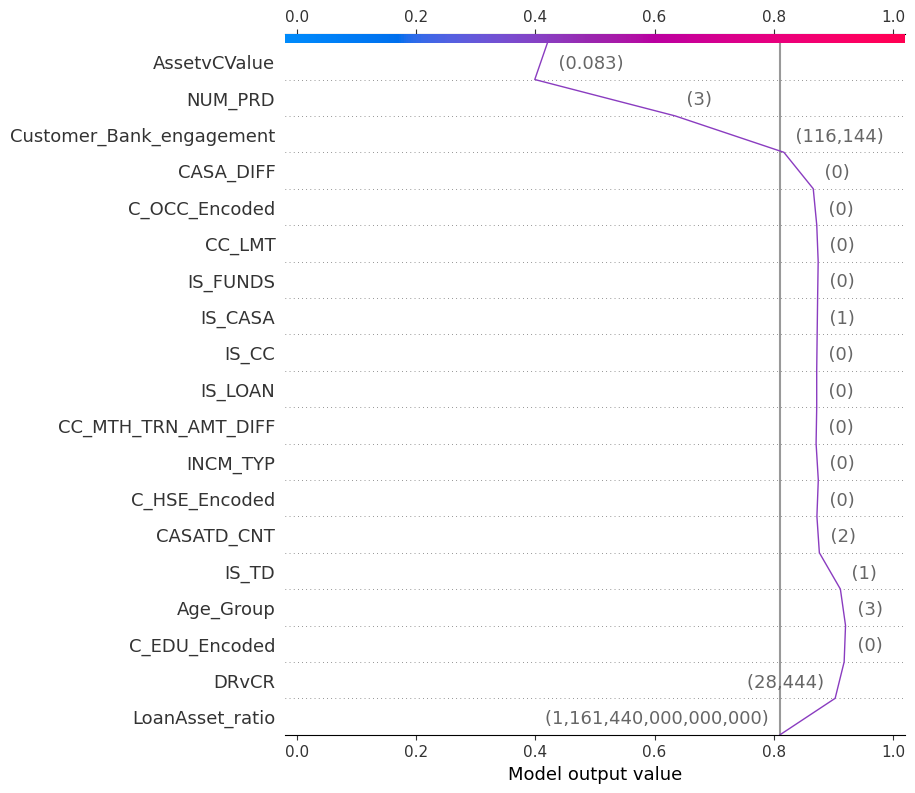

In [266]:
# Plot the observations individually with their corresponding feature values. The plots use the same feature order
# as the original plot.
for i in idx:
    shap.decision_plot(
        explainer.expected_value,
        sh[i],
        X.loc[T_mid.index[i]],
        feature_order=r.feature_idx,
        xlim=r.xlim,
        link='logit'
    )

(309, 19)


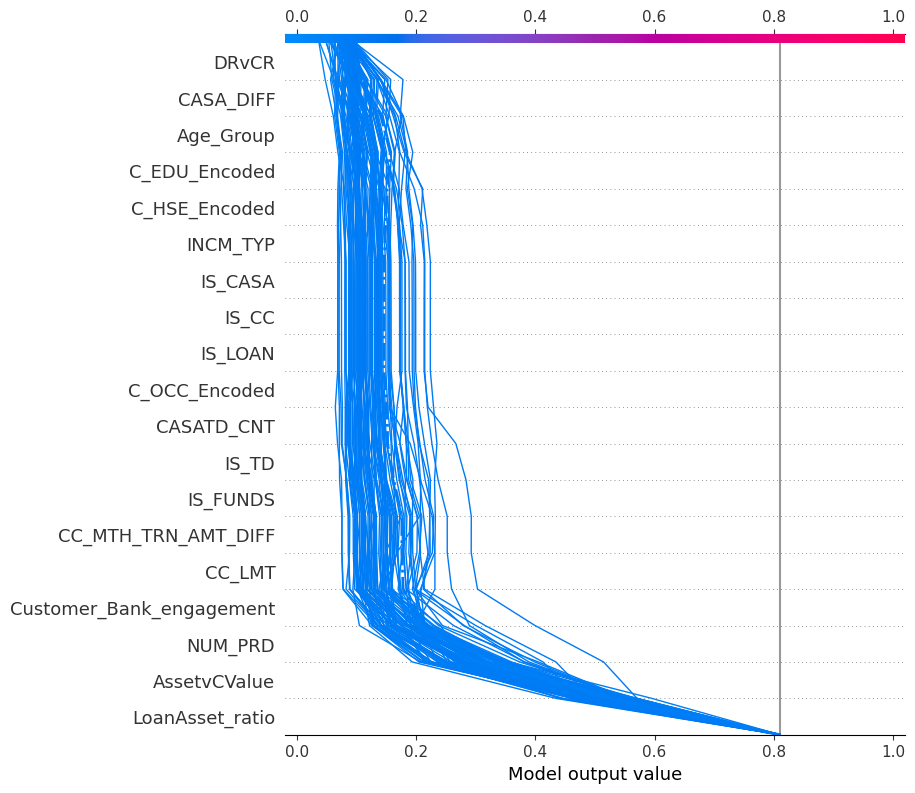

In [207]:
### For results interpretation and decision making between probability threshold of 0.01 and 0.1
# y_pred = xgb_best.predict_proba(X)[:, 1]  # Get predictions on the probability scale.
T_low = X[(y_pred >= 0.01) & (y_pred <= 0.1)]  # Select the top 1% of customers with the highest probability of being affluent.
print(T_low.shape)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sh = explainer.shap_values(T_low)[0:100,:]
shap.decision_plot(explainer.expected_value, sh, T_low, feature_order="hclust", link="logit", highlight=0)

In [191]:
# Force plot of 1 individual record
shap.force_plot(explainer.expected_value, shap_values[1,:], X.iloc[1,:])


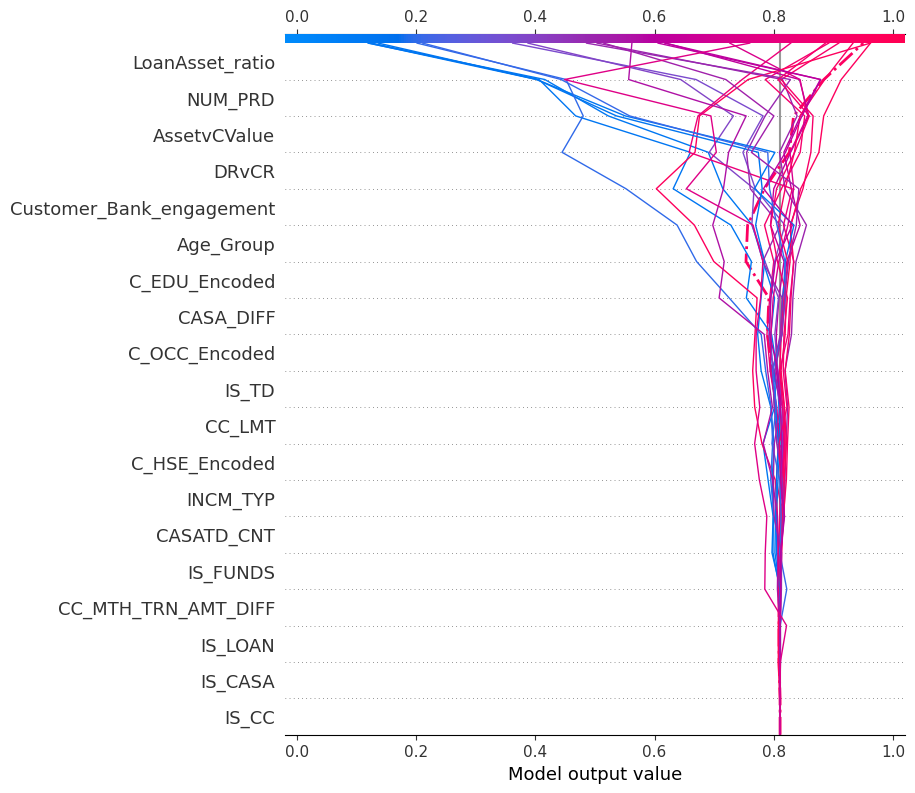

In [192]:
# Decision plot with random sample of X and shap values
shap.decision_plot(explainer.expected_value, shap_values[25:50,:], X, link='logit', highlight=0)